In [ ]:
!pip install summarytools

In [26]:
# Import libraries

import numpy as np
import pandas as pd
from summarytools import dfSummary
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Load data and read first 5 rows

df = pd.read_csv('/content/drive/MyDrive/marketing_data.csv')

df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [28]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [29]:
# Generate a report of our dataset

dfSummary(df)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[int64],Mean (sd) : 5592.2 (3246.7)min < med < max:0.0 < 5458.5 < 11191.0IQR (CV) : 5599.5 (1.7),"2,240 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACq0lEQVR4nO3bTU4iQRiH8bcGP0ow3eEjsOMCJrMgccMBZjmHnSO4cDFrbsDOxBAIjISmYVbuROkqS/qPz2+LJaTzWP1WE91+vzeg7n6c+gMAx7g49QfA+XDO3ZjZVeDyzX6/fzn0IqHiUzjnbrrd7u8sy9oh6xeLxcw59+dQrISKz3KVZVl7PB6/5Hm+rrJwPp/7x8fH9vPz85WZESrSy/N83e/3/wUsvXnvRUI9IOW8heoI9Q2p5y1Ud7ahRu6I2e3tbX88Hi9SzFuortahRsTmO53OrzzPWyHvWxSFL8vy7vr6+iHFvIXqahtqzO23KApvZnf39/d/e73eour66XTankwmze1226i6Fml8GOoJDxXBjzteQ/PeFyE74mw2i9oRy7K8NLPMOReynIPYG94NtQ6HipDHHbGhxVitVpdFUfwcDoeNRqNR6Q/MjIPYIR/tqEkf4p6jzWZz4b1vjkaj9WAwmFVZ+12v2TGOmlFDH+KWZZlZ+C0w2+12lyEL66DVap3impmd6eiQ7DAVewt8PXmv1+sHMws5ecuJvWZmcaND7CO9lBtLslBjboFm3/PkHXvNYkaH2PNI6o0l+eOp0FvgKQ9EpxZ6zcyiRofgLznM0m8stX2OiupiRofYLzlSbyyEekZiRoe6j1qEeoZCRoe6j1r8zxQkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokXBzzQ/P53Ff9xcvl0puZrVYr//T01PzK9arvrfq5Y9cf09d/5I6UrA562QkAAAAASUVORK5CYII="">",0(0.0%)
2,Year_Birth[int64],Mean (sd) : 1968.8 (12.0)min < med < max:1893.0 < 1970.0 < 1996.0IQR (CV) : 18.0 (164.3),59 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACcUlEQVR4nO3cMY7aQBSA4TdhITYgWwgFOi4QiYKSQ+SwOUIKTkBLRWeBkBHOOhjjdJEiJcvaM17mWf9XM8sUf7HG88ZUVSWA7z49ewPAe7w8ewNwyxgTisig4fJrVVWvLvfjCqF2iDEmnE6n36IomjRZfz6fT8aY7z7GSqjdMoiiaLJer1/jOM7rLEzTNNhsNpPj8TgQEUJF++I4zmez2c8GS0Pnm3GEhymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFXqJ6xPP0U3e/3vsv9+IJQPWJ7+qkoiqAsy695nv8QkSbv+r1FqH5pfPpJRGS/30+22+3wdrv12tjcMxGqh5qefjqdTt6efrJFqPijLMu+iETGmKZ/orUJAUKFiIhkWdYvimK5WCx6vV6v9r8dIu1OCBAqRETker2+BEEwXK1W+Xw+P9Vd3/aEAKHiL6PRqOl0gEiLEwL84A8VCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQocnG6BxWx+Z+fybRGqYzaz+V2ey7dFqO41ns3v8ly+LUJtSZPZ/C7P5dviYQoqECpUIFSoQKhQgVChAqFCBUKFCvyOCmcsr61888pKQoUTttdWPrqyklDhhM21le+5spJQ4ZTFtZVvvj7mYQoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFDKf/BtTx+IdR/4Foe/zwM1RgTiMjnD9iLT6LxePxluVzewjD8VWfh4XAIdrvdME3TUZIk1zprL5dLICKSZVmQJMmwzlrb9c/87jRNg0ef+Q2XKfNdF6QuEQAAAABJRU5ErkJggg=="">",0(0.0%)
3,Education[object],1. Graduation2. PhD3. Master4. 2n Cycle5. Basic,"1,127 (50.3%)486 (21.7%)370 (16.5%)203 (9.1%)54 (2.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACRUlEQVR4nO3bMWrjUBiF0V+DCZNGwhi8GC9iFjuL0G6MsYokpNEUU4WkiBV0JdnnbCCP8CHxjG4zjmNBwq+lD8DjEBsxYiOmqarnqnpa+iAb9D6O4+vSh9iS3eFw+NO27X7pg2zNMAyXpmn+Cu77dm3b7k+n02vXdW9LH2Yrrtfr777v9+fz+amqxPZNu6qqruvejsfjy9KH2ZjnpQ+wNS4IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMrur/JzNLH2RL/L+m2Q3DcOn7fl8+mbnJMAyXqnpf+hxb4rPw6XwWfqPGbpQUFwRi1vQa9Vq6c6tZV1kr3b9VrKuslR7DmtZVfnq5cy4IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbMKtZVS/99MlazrrJWun8+CyfGuooYFwRikq9Rr8kHF1tXWU8RWVdZT1GVXVdZTz04FwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiIyayrrKeoiq4rrKewmfhxFhXEfOTJ5snFTeZPHgxYOFWkwYvBixM8ZPBiwELN/GjLjFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZiJq2rrKWYYvK6ylqKW9kgEGNdRcxXTzZPLGbxaV1lNcVcPqyrrKaY01frKqspZuFHXWLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEfFhXWU0xp0/rKqsp5mKDQIx1FTEuCMSIjZh/O3UON/LmBqQAAAAASUVORK5CYII="">",0(0.0%)
4,Marital_Status[object],1. Married2. Together3. Single4. Divorced5. Widow6. Alone7. Absurd8. YOLO,864 (38.6%)580 (25.9%)480 (21.4%)232 (10.4%)77 (3.4%)3 (0.1%)2 (0.1%)2 (0.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZl

**Observations**
1. 2,240 customers with 29 attributes.
2. Our dataset has 24 null values in the ' Income ' column but no duplicates.
3. We have integer, float and categorical attributes describing the customers, their purchases and their respective responses to various campaigns.
4. Some columns need cleaning; changing datatypes, renaming
5. 'ID', 'Z_CostContact' and 'Z_Revenue' do not add much information to our analysis.


### **Cleaning**

---



In [30]:
# Remove leading and trailing whitespace from column names
df.columns = df.columns.str.strip()

df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [31]:
# Drop columns 'Z_CostContact', 'Z_Revenue' and 'ID'
df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)

# Change to appropriate datatype
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Year_Birth           2240 non-null   int64         
 1   Education            2240 non-null   object        
 2   Marital_Status       2240 non-null   object        
 3   Income               2216 non-null   float64       
 4   Kidhome              2240 non-null   int64         
 5   Teenhome             2240 non-null   int64         
 6   Dt_Customer          2240 non-null   datetime64[ns]
 7   Recency              2240 non-null   int64         
 8   MntWines             2240 non-null   int64         
 9   MntFruits            2240 non-null   int64         
 10  MntMeatProducts      2240 non-null   int64         
 11  MntFishProducts      2240 non-null   int64         
 12  MntSweetProducts     2240 non-null   int64         
 13  MntGoldProds         2240 non-nul

In [32]:
# Missing values

df.isnull().sum()[df.isnull().sum() != 0]

Income    24
dtype: int64

In [33]:
# Drop rows with missing values

df = df.dropna()

df.shape

(2216, 26)

### **Feature Engineering**

---



To perform **customer profile analysis**, we need to engineer some features




1. Age : We will extract the age from the customers' year of birth ('Year_Birth')
2. Customer_Duration : This is to determine how long they have been our customer.
3. Marital_Status : Category reduction is important for this column to make the data easier to understand.

In [34]:
# Define a function that pre-processes the data

def preprocess_data(df):
    """
    Preprocesses the DataFrame by creating an 'Age' column, categorizing 'Marital_Status',
    and calculating the number of months as a customer.

    Args:
        df: Pandas DataFrame containing the data.

    Returns:
        Preprocessed Pandas DataFrame.
    """
    # Create 'Age' column
    df['Age'] = date.today().year - df['Year_Birth']

    # Define a function that categorizes 'Marital_Status'
    def categorize_marital_status(Marital_Status):
        if Marital_Status in ["Single", "Alone", "Absurd", "YOLO"]:
            return "Single"
        elif Marital_Status == "Together":
            return "Married"
        else:
            return Marital_Status

    df["Marital_Status"] = df["Marital_Status"].apply(categorize_marital_status)

    # Calculate the number of months as a customer
    df['Customer_Duration'] = (pd.to_datetime("today") - df['Dt_Customer']) / np.timedelta64(1, 'M')
    df['Customer_Duration'] = df['Customer_Duration'].round()

    return df

df = preprocess_data(df)

In [35]:
df['Marital_Status'].value_counts();

**Age**

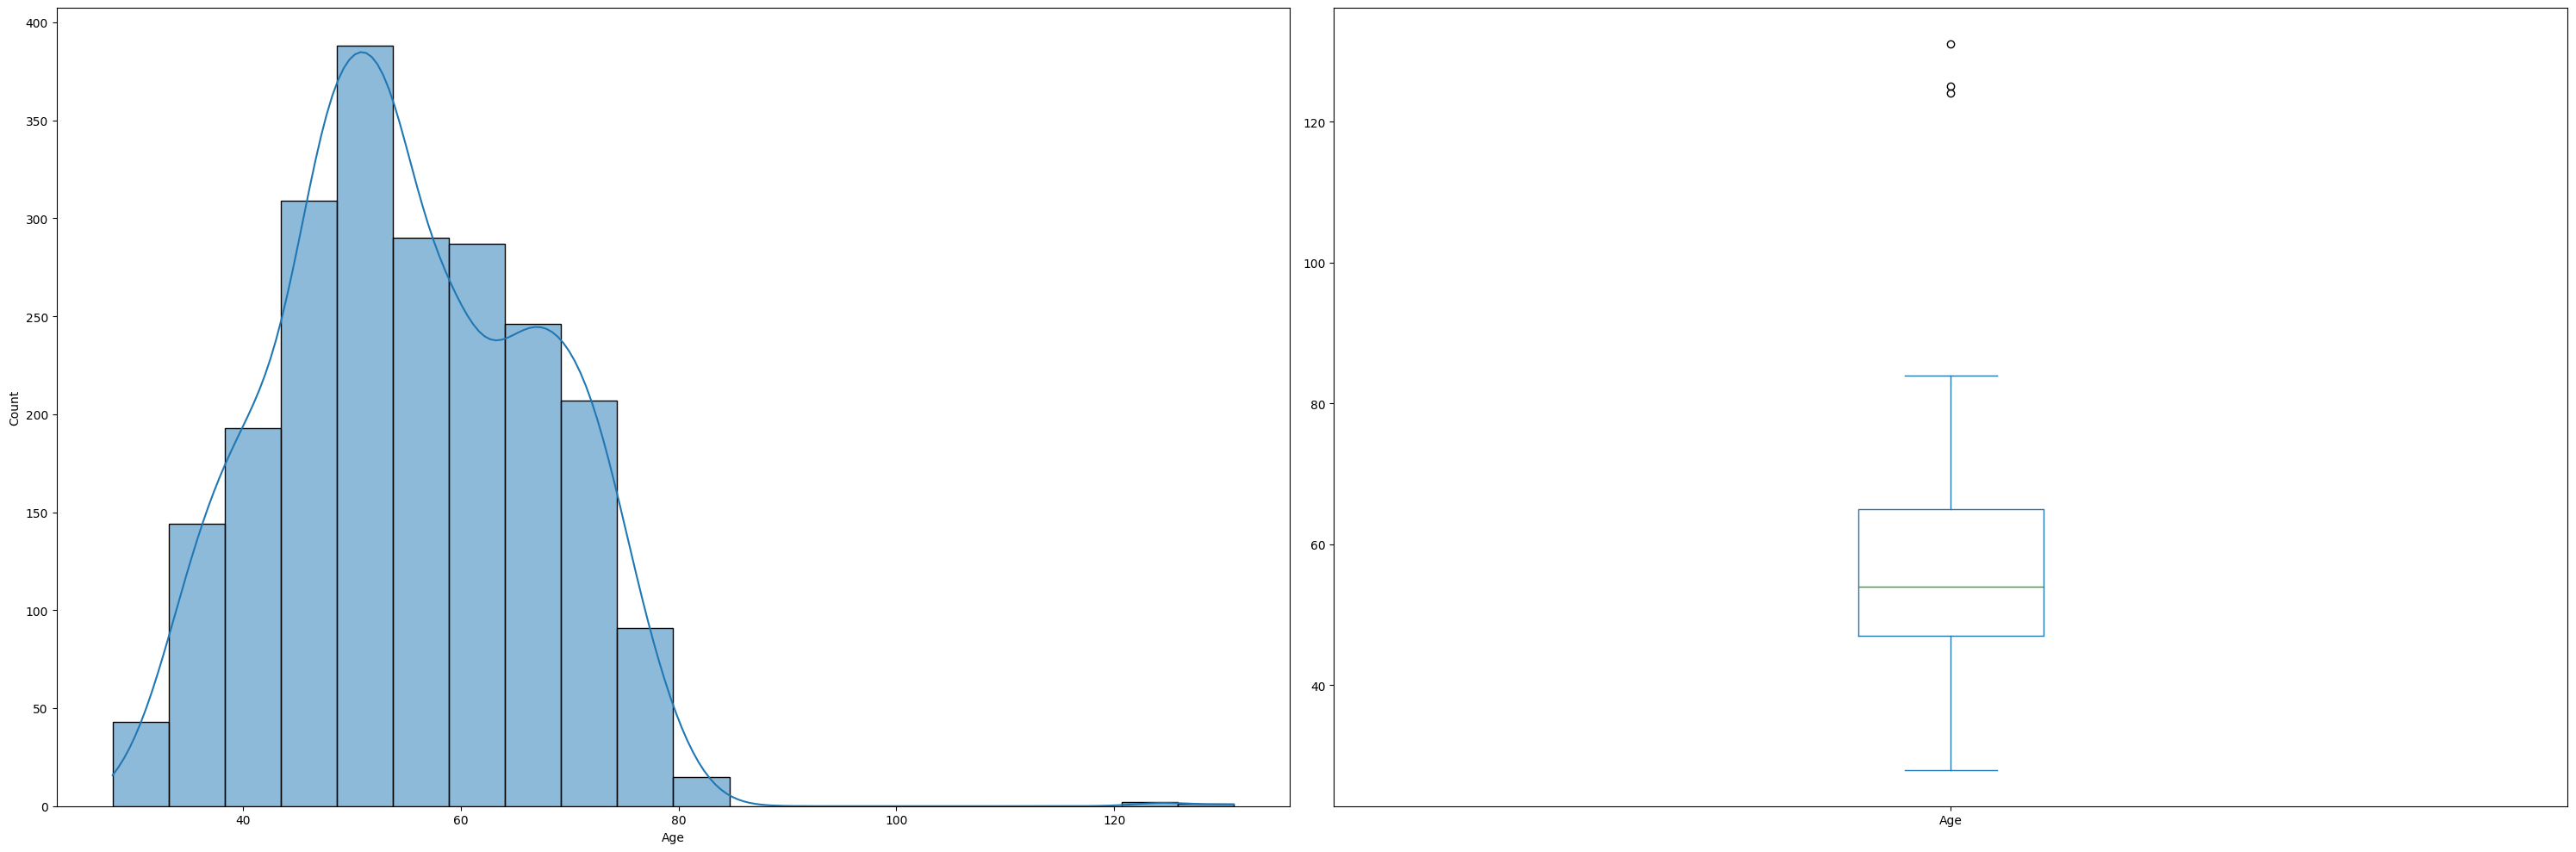

In [36]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Age'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Age'].plot(kind='box');
plt.tight_layout()


In [37]:
df['Age'].describe()

count    2216.000000
mean       55.179603
std        11.985554
min        28.000000
25%        47.000000
50%        54.000000
75%        65.000000
max       131.000000
Name: Age, dtype: float64

**Income**

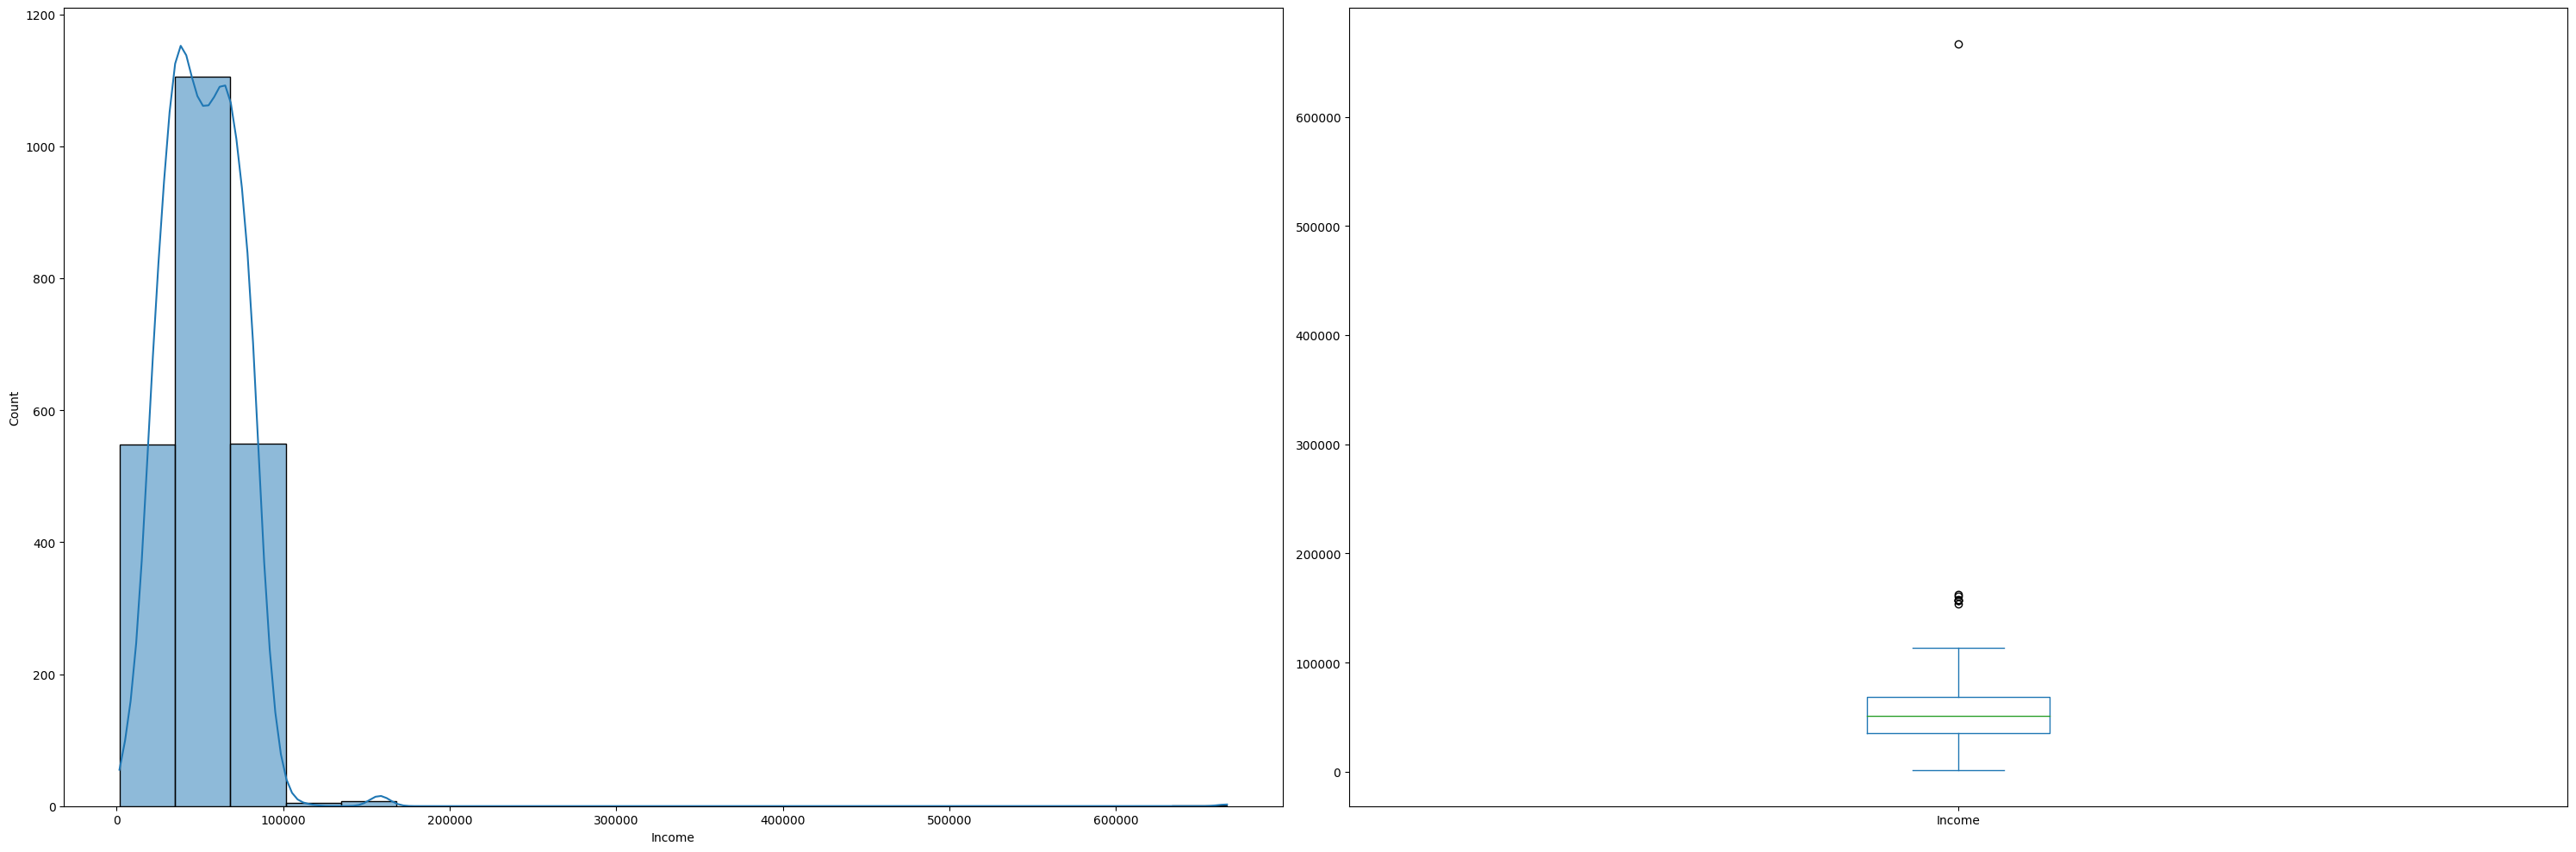

In [38]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Income'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Income'].plot(kind='box');
plt.tight_layout()


**Duration as a Customer**

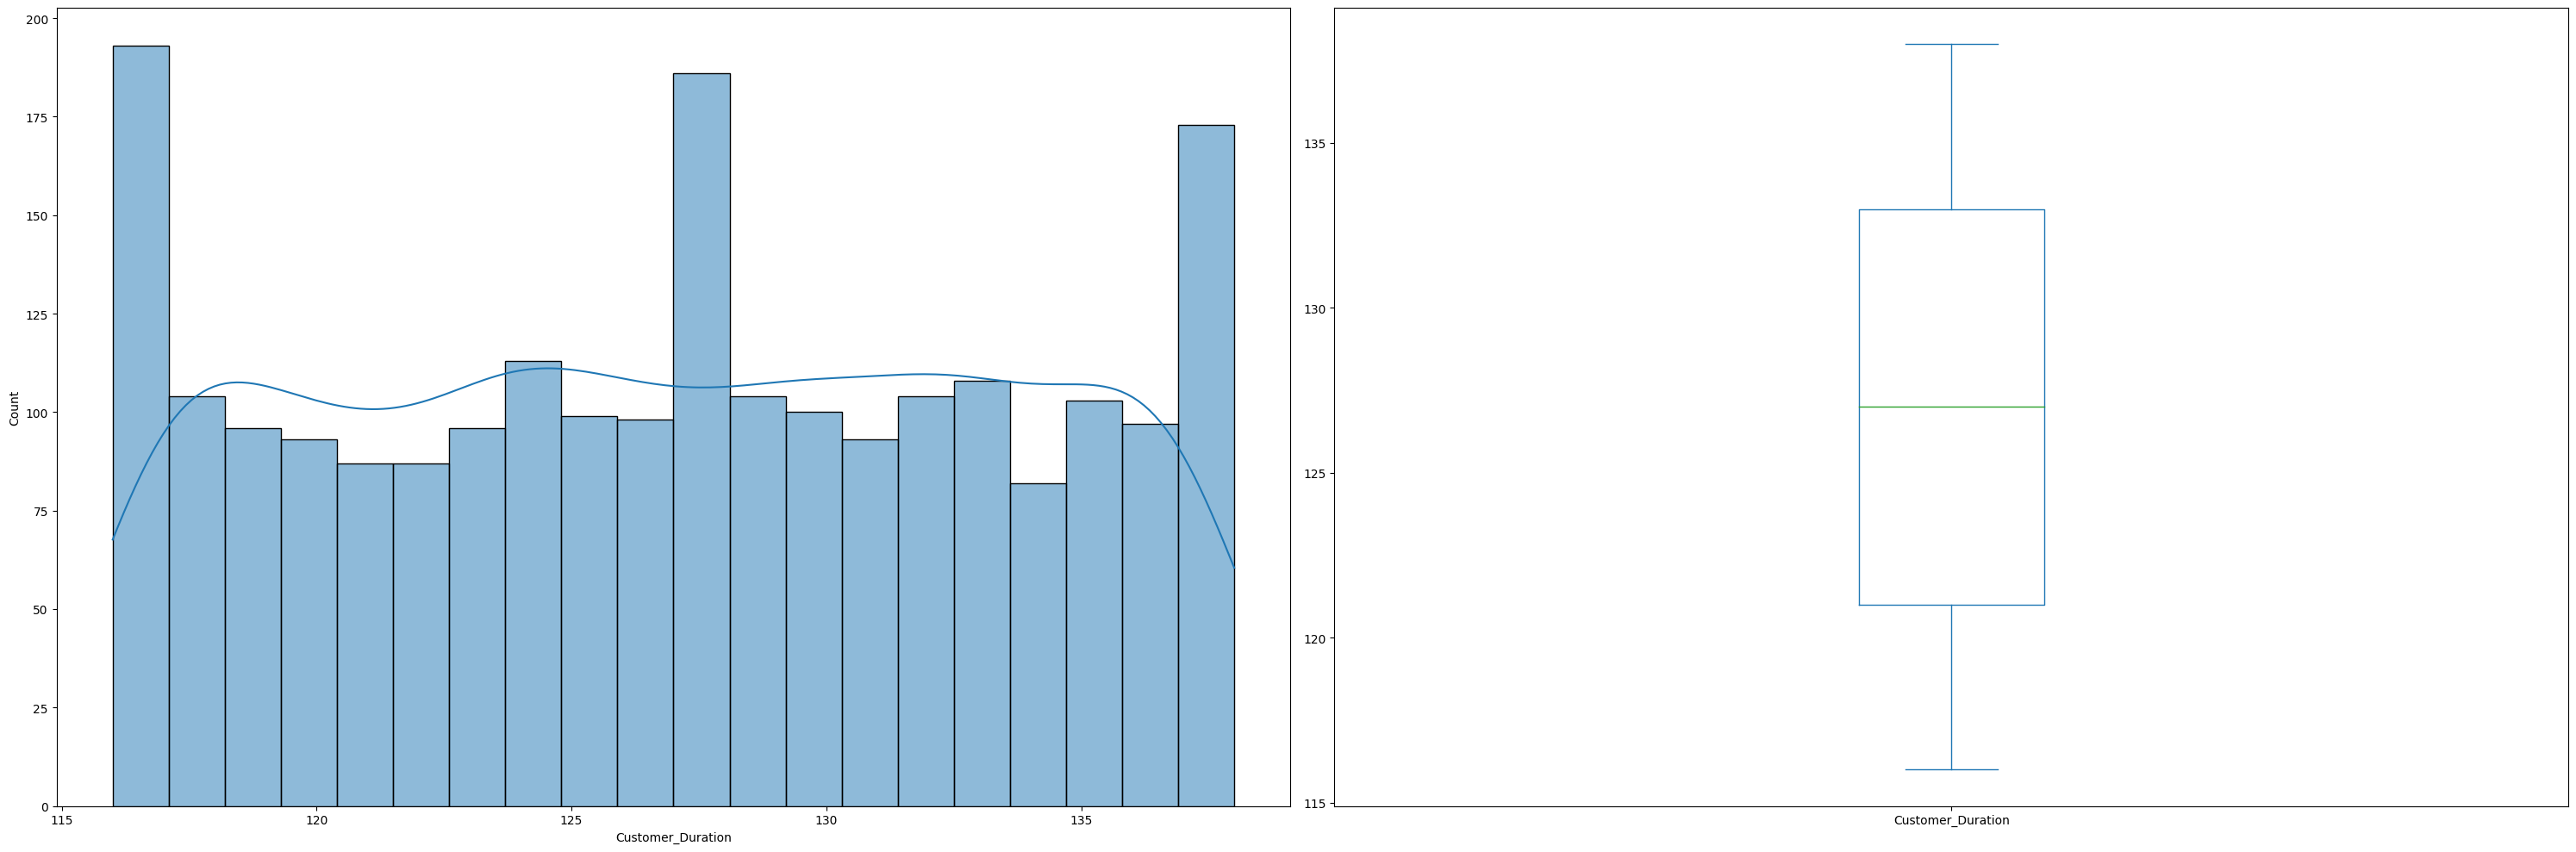

In [39]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Customer_Duration'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Customer_Duration'].plot(kind='box');
plt.tight_layout()


**Recency**

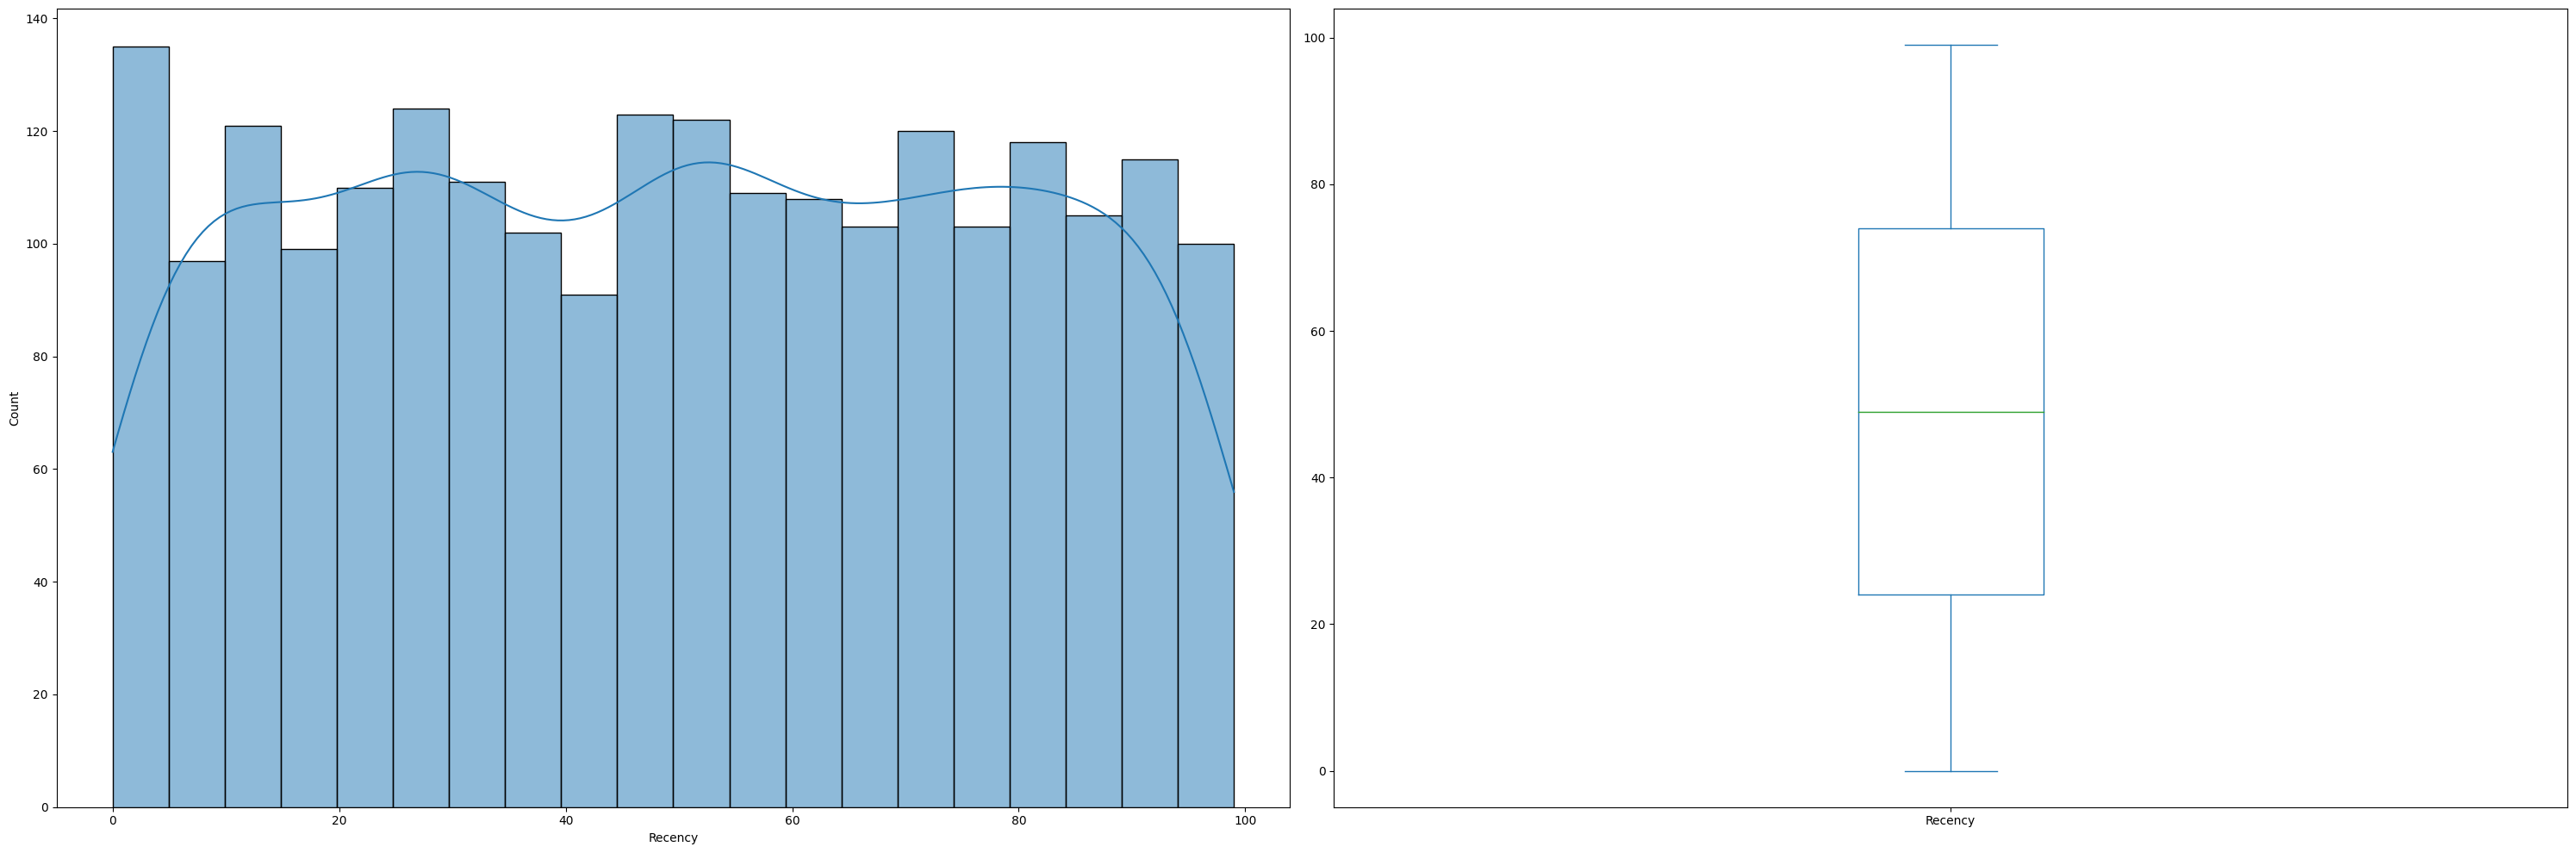

In [40]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.histplot(df['Recency'],kde=True,bins=20)
plt.subplot(1, 2, 2)
df['Recency'].plot(kind='box');
plt.tight_layout()


In [41]:
pd.crosstab(df['Marital_Status'], df['Response'])

Response,0,1
Marital_Status,,
Divorced,184,48
Married,1272,158
Single,369,109
Widow,58,18
